

---



**Sina Beyrami**

**400105433**



---



# Implementation

**Libraries**

In [477]:
import numpy as np
import heapq
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

**Constants**

In [478]:
LAMBD = 0.5
P1 = 0.6
P_ERROR = 0.15
ALPHA = 0.5
SIM_TIME = 20000
X = 0.2

service_time_human = {
    1: {1:  8.0, 2: 10.0},
    2: {1: 10.0, 2: 14.0},
    3: {1: 18.0, 2: 16.0},
    0: {1: 4.0 , 2: 6.0}
}

STANDARD_MODE = 0
ROBOTIC_MODE = 1

ARRIVAL = "ARRIVAL"
DEPARTURE = "DEPARTURE"

GLOBAL_ARRIVAL_SEQ = 0
patient_id_counter = 0

random.seed(12345)

**Classes**

In [479]:
class Patient:
    def __init__(self, patient_id, arrival_time, disability, destination, arrival_seq):
        self.id = patient_id
        self.arrival_time = arrival_time
        self.disability = disability
        self.destination = destination
        self.start_service_time = None
        self.end_service_time = None
        self.arrival_seq = arrival_seq


class Server:
    def __init__(self, server_id, is_robot=False):
        self.id = server_id
        self.is_robot = is_robot
        self.is_busy = False
        self.current_patient = None
        self.time_service_ends = 0.0
        self.queue = []

**Functions**

In [480]:
def exponential(r):
    return np.random.exponential(1.0 / r)

def get_next_arrival_time(current_time, lam):
    return current_time + exponential(lam)

In [481]:
def draw_disability():
    rnd = random.random()
    if rnd > X:
        return 0
    else:
        rnd2 = random.random()
        if rnd2 < 1/3:
            return 1
        elif rnd2 < 2/3:
            return 2
        else:
            return 3

def draw_destination(p1):
    return 1 if random.random() < p1 else 2

In [482]:
def get_base_service_time(disability, destination):
    return service_time_human[disability][destination]

def get_actual_service_time(disability, destination, is_robot):
    base = get_base_service_time(disability, destination)
    if is_robot and disability != 0:
        base *= ALPHA
        total = 0.0
        while True:
            total += base
            if random.random() > P_ERROR:
                return total
    else:
        return base

In [483]:
def push_to_queue(server, patient):
    if server.is_robot:
        disabled_priority = 0 if patient.disability != 0 else 1
        heapq.heappush(server.queue, (disabled_priority, patient.arrival_seq, patient))
    else:
        server.queue.append(patient)


def pop_from_queue(server):
    if server.is_robot:
        if server.queue:
            _, _, patient = heapq.heappop(server.queue)
            return patient
        else:
            return None
    else:
        if server.queue:
            return server.queue.pop(0)
        else:
            return None

In [484]:
def choose_server(servers, mode, disability):
    if mode == STANDARD_MODE:
        s1, s2 = servers
        if len(s1.queue) <= len(s2.queue):
            return s1
        else:
            return s2
    else:
        s1, s2 = servers
        if disability != 0:
            return s2
        else:
            if len(s1.queue) <= len(s2.queue):
                return s1
            else:
                return s2

**Simulation Implementation**

In [485]:
def run_simulation(sim_mode=STANDARD_MODE, max_time=SIM_TIME):
    global GLOBAL_ARRIVAL_SEQ
    GLOBAL_ARRIVAL_SEQ = 0

    event_list = []
    current_time = 0.0
    patient_id_counter = 0

    server_stats = [
        {"last_event_time": 0.0,
         "area_queue": 0.0,
         "busy_time": 0.0,
         "waiting_time": 0.0,
         "served_count": 0}
        for _ in range(2)
    ]

    total_sys_time_disabled = 0.0
    count_sys_time_disabled = 0
    total_sys_time_non_disabled = 0.0
    count_sys_time_non_disabled = 0

    arrivals_disabled = 0
    arrivals_non_disabled = 0

    last_global_event_time = 0.0

    if sim_mode == STANDARD_MODE:
        servers = [Server(1, is_robot=False),
                   Server(2, is_robot=False)]
    else:
        servers = [Server(1, is_robot=False),
                   Server(2, is_robot=True)]

    num_arrivals = 0
    total_wait_time = 0.0
    total_system_time = 0.0
    max_queue_length = 0

    def schedule_arrival(at_time):
        nonlocal arrivals_disabled, arrivals_non_disabled
        global GLOBAL_ARRIVAL_SEQ
        global patient_id_counter
        patient_id_counter   += 1
        GLOBAL_ARRIVAL_SEQ   += 1
        p = Patient(patient_id_counter,
                    arrival_time=at_time,
                    disability=draw_disability(),
                    destination=draw_destination(P1),
                    arrival_seq=GLOBAL_ARRIVAL_SEQ)

        if p.disability != 0:
            arrivals_disabled += 1
        else:
            arrivals_non_disabled += 1

        heapq.heappush(event_list, (p.arrival_time, ARRIVAL, p))

    schedule_arrival(get_next_arrival_time(current_time, LAMBD))

    while event_list:
        event_time, event_type, patient = heapq.heappop(event_list)
        current_time = event_time

        if current_time > max_time:
            break

        time_diff = current_time - last_global_event_time
        for i, sv in enumerate(servers):
            server_stats[i]["area_queue"] += len(sv.queue) * time_diff
            if sv.is_busy:
                server_stats[i]["busy_time"] += time_diff
        last_global_event_time = current_time

        if event_type == ARRIVAL:
            num_arrivals += 1

            server_chosen = choose_server(servers, sim_mode, patient.disability)

            if not server_chosen.is_busy:
                server_chosen.is_busy = True
                patient.start_service_time = current_time
                stime = get_actual_service_time(patient.disability, patient.destination, server_chosen.is_robot)
                finish = current_time + stime
                patient.end_service_time = finish
                server_chosen.current_patient = patient
                server_chosen.time_service_ends = finish
                heapq.heappush(event_list, (finish, DEPARTURE, patient))
            else:
                push_to_queue(server_chosen, patient)
                q_len = sum(len(s.queue) for s in servers)
                if q_len > max_queue_length:
                    max_queue_length = q_len

            next_arrival = get_next_arrival_time(current_time, LAMBD)
            schedule_arrival(next_arrival)

        elif event_type == DEPARTURE:
            departing_server = None
            for sv in servers:
                if sv.current_patient and sv.current_patient.id == patient.id:
                    departing_server = sv
                    break

            if departing_server is not None:
                wait_time = patient.start_service_time - patient.arrival_time
                sys_time = patient.end_service_time - patient.arrival_time
                total_wait_time += wait_time
                total_system_time += sys_time

                i = servers.index(departing_server)
                server_stats[i]["waiting_time"] += wait_time
                server_stats[i]["served_count"] += 1

                if patient.disability != 0:
                    total_sys_time_disabled += sys_time
                    count_sys_time_disabled += 1
                else:
                    total_sys_time_non_disabled += sys_time
                    count_sys_time_non_disabled += 1

                departing_server.is_busy = False
                departing_server.current_patient = None
                departing_server.time_service_ends = 0.0

                next_in_queue = pop_from_queue(departing_server)
                if next_in_queue:
                    departing_server.is_busy = True
                    next_in_queue.start_service_time = current_time
                    stime = get_actual_service_time(
                        next_in_queue.disability, next_in_queue.destination,
                        departing_server.is_robot
                    )
                    finish = current_time + stime
                    next_in_queue.end_service_time = finish
                    departing_server.current_patient = next_in_queue
                    departing_server.time_service_ends = finish
                    heapq.heappush(event_list, (finish, DEPARTURE, next_in_queue))

        else:
            raise ValueError("Unknown event type encountered!")

    final_stop_time = min(current_time, max_time)

    if final_stop_time > last_global_event_time:
        time_diff = final_stop_time - last_global_event_time
        for i, sv in enumerate(servers):
            server_stats[i]["area_queue"] += len(sv.queue) * time_diff
            if sv.is_busy:
                server_stats[i]["busy_time"] += time_diff

    for i, sv in enumerate(servers):
        if sv.is_busy and sv.current_patient is not None:
            p = sv.current_patient

            partial_wait = p.start_service_time - p.arrival_time
            partial_sys_time = final_stop_time - p.arrival_time

            total_wait_time += partial_wait
            total_system_time += partial_sys_time

            server_stats[i]["waiting_time"] += partial_wait
            server_stats[i]["served_count"] += 1

            if p.disability != 0:
                total_sys_time_disabled += partial_sys_time
                count_sys_time_disabled += 1
            else:
                total_sys_time_non_disabled += partial_sys_time
                count_sys_time_non_disabled += 1


        while sv.queue:
            p = pop_from_queue(sv)
            partial_wait = final_stop_time - p.arrival_time
            partial_sys_time = partial_wait

            total_wait_time += partial_wait
            total_system_time += partial_sys_time

            server_stats[i]["waiting_time"] += partial_wait
            server_stats[i]["served_count"] += 1

            if p.disability != 0:
                total_sys_time_disabled += partial_sys_time
                count_sys_time_disabled += 1
            else:
                total_sys_time_non_disabled += partial_sys_time
                count_sys_time_non_disabled += 1

    avg_wait = total_wait_time / num_arrivals if num_arrivals > 0 else 0.0
    avg_sys_time = total_system_time / num_arrivals if num_arrivals > 0 else 0.0

    sim_end_time = final_stop_time
    avg_Lq_server1 = 0.0
    avg_Lq_server2 = 0.0
    if sim_end_time > 0:
        avg_Lq_server1 = server_stats[0]["area_queue"] / sim_end_time
        avg_Lq_server2 = server_stats[1]["area_queue"] / sim_end_time

    avg_wq_server1 = 0.0
    if server_stats[0]["served_count"] > 0:
        avg_wq_server1 = server_stats[0]["waiting_time"] / server_stats[0]["served_count"]
    avg_wq_server2 = 0.0
    if server_stats[1]["served_count"] > 0:
        avg_wq_server2 = server_stats[1]["waiting_time"] / server_stats[1]["served_count"]

    avg_w_disabled = 0.0
    if count_sys_time_disabled > 0:
        avg_w_disabled = total_sys_time_disabled / count_sys_time_disabled
    avg_w_non_disabled = 0.0
    if count_sys_time_non_disabled > 0:
        avg_w_non_disabled = total_sys_time_non_disabled / count_sys_time_non_disabled

    util_server1 = 0.0
    util_server2 = 0.0
    if sim_end_time > 0:
        util_server1 = server_stats[0]["busy_time"] / sim_end_time
        util_server2 = server_stats[1]["busy_time"] / sim_end_time

    return {
        'num_arrivals': num_arrivals,
        'max_queue_length': max_queue_length,
        'avg_wait_time': avg_wait,
        'avg_system_time': avg_sys_time,
        'simulation_end': current_time,
        'avg_Lq_server1': avg_Lq_server1,
        'avg_Lq_server2': avg_Lq_server2,
        'avg_Wq_server1': avg_wq_server1,
        'avg_Wq_server2': avg_wq_server2,
        'avg_W_disabled': avg_w_disabled,
        'avg_W_non_disabled': avg_w_non_disabled,
        'arrivals_disabled': arrivals_disabled,
        'arrivals_non_disabled': arrivals_non_disabled,
        'util_server1': util_server1,
        'util_server2': util_server2
    }

# Run And Results

**A sample run**

In [486]:
print("=== STANDARD MODE ===")
res_std = run_simulation(STANDARD_MODE, SIM_TIME)
for metric in res_std.keys():
    print(f"{metric}: {res_std[metric]}")

print("\n\n=== ROBOTIC MODE ===")
random.seed(12345)
res_robot = run_simulation(ROBOTIC_MODE, SIM_TIME)
for metric_rob in res_robot.keys():
    print(f"{metric_rob}: {res_robot[metric_rob]}")

=== STANDARD MODE ===
num_arrivals: 10013
max_queue_length: 3779
avg_wait_time: 3876.381354695981
avg_system_time: 3880.375197868017
simulation_end: 20000.261715228833
avg_Lq_server1: 970.6063588965893
avg_Lq_server2: 970.1039663319517
avg_Wq_server1: 3889.4264031119637
avg_Wq_server2: 3863.41683127022
avg_W_disabled: 3877.245286210812
avg_W_non_disabled: 3881.209840976608
arrivals_disabled: 2108
arrivals_non_disabled: 7906
util_server1: 0.9998439447967683
util_server2: 0.9996736392827803


=== ROBOTIC MODE ===
num_arrivals: 9995
max_queue_length: 2719
avg_wait_time: 2761.943308515478
avg_system_time: 2765.944232177887
simulation_end: 20000.712103514812
avg_Lq_server1: 690.0314511784655
avg_Lq_server2: 690.2497172521469
avg_Wq_server1: 2495.592951820851
avg_Wq_server2: 3091.8240414429865
avg_W_disabled: 24.954268476183277
avg_W_non_disabled: 3474.9221172607877
arrivals_disabled: 2054
arrivals_non_disabled: 7942
util_server1: 0.9998472054647869
util_server2: 0.9996143948242594


**Probability of error** effect on Average System Time

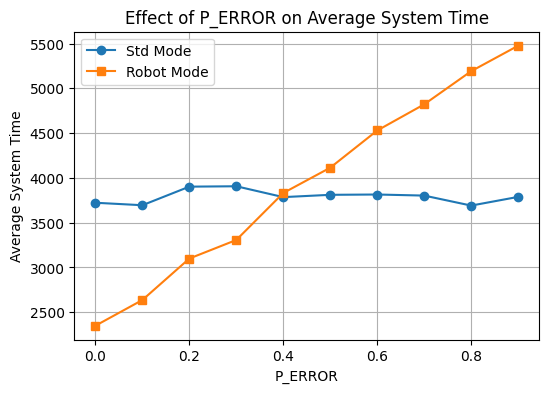

In [487]:
p_error_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_std_sys_time = []
results_robot_sys_time = []

for val in p_error_values:
    P_ERROR = val

    random.seed(12345)

    res_std = run_simulation(STANDARD_MODE, SIM_TIME)
    results_std_sys_time.append(res_std['avg_system_time'])

    random.seed(12345)

    res_robot = run_simulation(ROBOTIC_MODE, SIM_TIME)
    results_robot_sys_time.append(res_robot['avg_system_time'])

plt.figure(figsize=(6,4))
plt.plot(p_error_values, results_std_sys_time, 'o-', label='Std Mode')
plt.plot(p_error_values, results_robot_sys_time, 's-', label='Robot Mode')
plt.xlabel('P_ERROR')
plt.ylabel('Average System Time')
plt.title('Effect of P_ERROR on Average System Time')
plt.legend()
plt.grid(True)
plt.show()


**Simulation Time** effect on maximum queue length

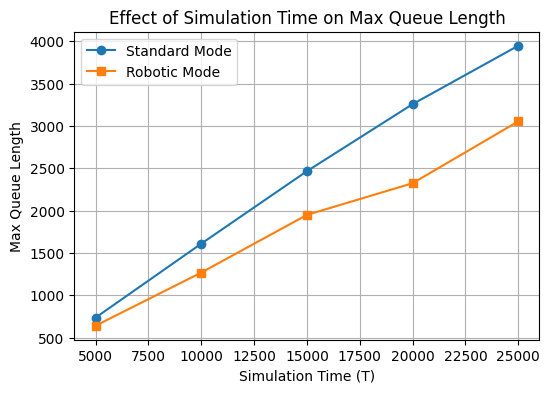

In [488]:
LAMBD = 0.5
P1 = 0.6
P_ERROR = 0.15
ALPHA = 0.5
X = 0.15

T_values = [5000, 10000, 15000, 20000, 25000]
max_queue_std = []
max_queue_robot = []

for t_val in T_values:
    random.seed(12345)
    res_std = run_simulation(STANDARD_MODE, max_time=t_val)
    max_queue_std.append(res_std['max_queue_length'])

    random.seed(12345)
    res_robot = run_simulation(ROBOTIC_MODE, max_time=t_val)
    max_queue_robot.append(res_robot['max_queue_length'])

plt.figure(figsize=(6,4))
plt.plot(T_values, max_queue_std, 'o-', label='Standard Mode')
plt.plot(T_values, max_queue_robot, 's-', label='Robotic Mode')
plt.xlabel('Simulation Time (T)')
plt.ylabel('Max Queue Length')
plt.title('Effect of Simulation Time on Max Queue Length')
plt.legend()
plt.grid(True)
plt.show()

**Percentage of disable patients** effect of Average System Time

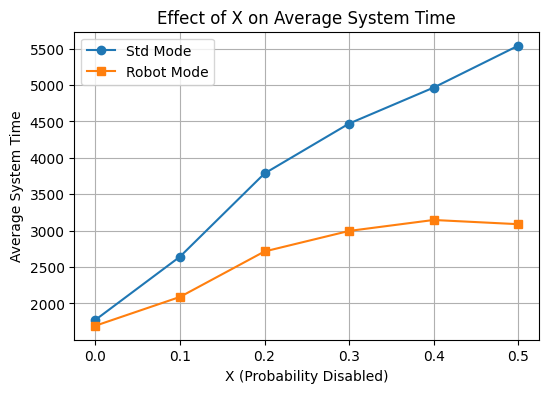

In [499]:
LAMBD = 0.5
P1 = 0.6
P_ERROR = 0.15
ALPHA = 0.5
SIM_TIME = 20000

X_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

results_std_arrivals_dis = []
results_robot_arrivals_dis = []

for x_val in X_values:
    X = x_val
    random.seed(12345)
    res_std = run_simulation(STANDARD_MODE)
    results_std_arrivals_dis.append(res_std['avg_system_time'])

    random.seed(12345)
    res_robot = run_simulation(ROBOTIC_MODE)
    results_robot_arrivals_dis.append(res_robot['avg_system_time'])

plt.figure(figsize=(6,4))
plt.plot(X_values, results_std_arrivals_dis, 'o-', label='Std Mode')
plt.plot(X_values, results_robot_arrivals_dis, 's-', label='Robot Mode')
plt.xlabel('X (Probability Disabled)')
plt.ylabel('Average System Time')
plt.title('Effect of X on Average System Time')
plt.legend()
plt.grid(True)
plt.show()

**Speedup Multiplier** effect of Average System Time

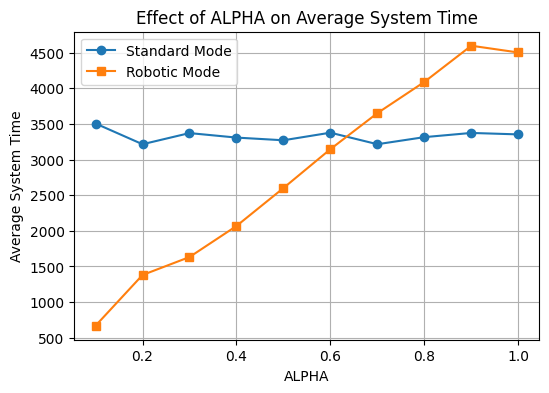

In [490]:
LAMBD = 0.5
P1 = 0.6
P_ERROR = 0.2
SIM_TIME = 20000
X = 0.15


alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

avg_sys_std = []
avg_sys_robot = []

for alpha in alpha_values:
    ALPHA = alpha

    random.seed(12345)
    res_std = run_simulation(STANDARD_MODE, SIM_TIME)
    avg_sys_std.append(res_std['avg_system_time'])

    random.seed(12345)
    res_robot = run_simulation(ROBOTIC_MODE, SIM_TIME)
    avg_sys_robot.append(res_robot['avg_system_time'])

plt.figure(figsize=(6,4))
plt.plot(alpha_values, avg_sys_std, 'o-', label='Standard Mode')
plt.plot(alpha_values, avg_sys_robot, 's-', label='Robotic Mode')
plt.xlabel('ALPHA')
plt.ylabel('Average System Time')
plt.title('Effect of ALPHA on Average System Time')
plt.legend()
plt.grid(True)
plt.show()

**Probability of first destination** effect on Average Wait Time

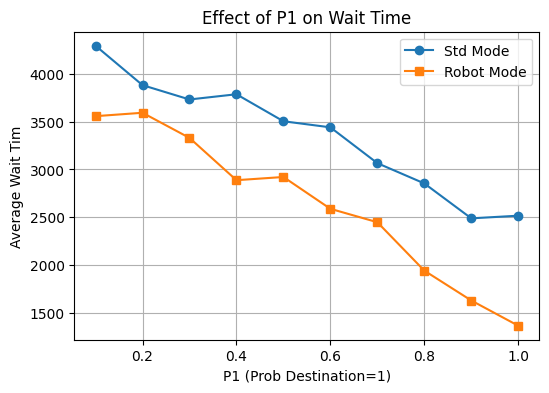

In [491]:
LAMBD = 0.5
ALPHA = 0.5
P_ERROR = 0.2
SIM_TIME = 20000
X = 0.15

P1_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results_std_W_disabled = []
results_robot_W_disabled = []

for p1_val in P1_values:
    P1 = p1_val
    random.seed(12345)
    res_std = run_simulation(STANDARD_MODE)
    results_std_W_disabled.append(res_std['avg_wait_time'])

    random.seed(12345)
    res_robot = run_simulation(ROBOTIC_MODE)
    results_robot_W_disabled.append(res_robot['avg_wait_time'])

plt.figure(figsize=(6,4))
plt.plot(P1_values, results_std_W_disabled, 'o-', label='Std Mode')
plt.plot(P1_values, results_robot_W_disabled, 's-', label='Robot Mode')
plt.xlabel('P1 (Prob Destination=1)')
plt.ylabel('Average Wait Tim')
plt.title('Effect of P1 on Wait Time')
plt.legend()
plt.grid(True)
plt.show()

Effect of combinations of **speedup factor** and **probability of error** on Average System Time

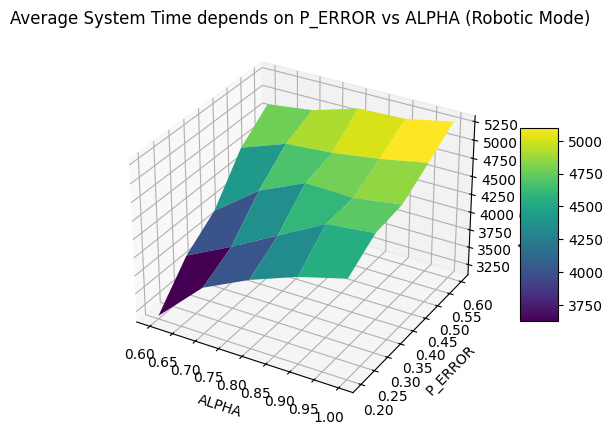

In [494]:
LAMBD = 0.5
P1 = 0.6
SIM_TIME = 20000
X = 0.15

p_error_values = [0.2, 0.3, 0.4, 0.5, 0.6]
alpha_values   = [0.6, 0.7, 0.8, 0.9, 1.0]

avg_sys_time_matrix = np.zeros((len(p_error_values), len(alpha_values)))

for i, pe in enumerate(p_error_values):
    for j, alpha in enumerate(alpha_values):
        P_ERROR = pe
        ALPHA   = alpha

        random.seed(12345)

        res = run_simulation(ROBOTIC_MODE, SIM_TIME)

        avg_sys_time_matrix[i, j] = res['avg_system_time']

p_error_arr = np.array(p_error_values)
alpha_arr   = np.array(alpha_values)

P_error_mesh, Alpha_mesh = np.meshgrid(alpha_arr, p_error_arr)

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P_error_mesh,
    Alpha_mesh,
    avg_sys_time_matrix,
    cmap='viridis',
    edgecolor='none'
)

ax.set_xlabel('ALPHA')
ax.set_ylabel('P_ERROR')
ax.set_zlabel('Avg System Time')
ax.set_title('Average System Time depends on P_ERROR vs ALPHA (Robotic Mode)')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

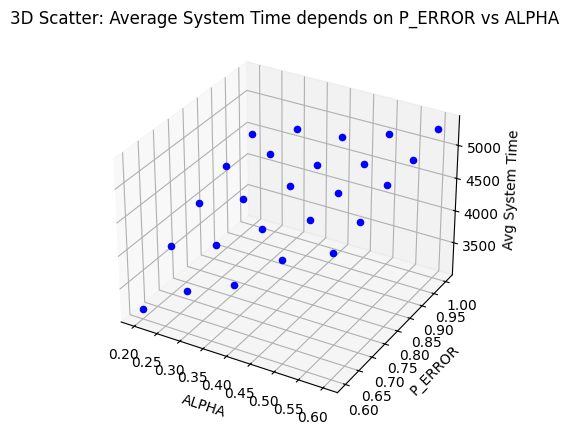

In [495]:
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection='3d')

for i, pe in enumerate(p_error_values):
    for j, alpha in enumerate(alpha_values):
        z_val = avg_sys_time_matrix[i, j]
        ax.scatter(pe, alpha, z_val, color='blue')

ax.set_xlabel('ALPHA')
ax.set_ylabel('P_ERROR')
ax.set_zlabel('Avg System Time')
ax.set_title('3D Scatter: Average System Time depends on P_ERROR vs ALPHA')
plt.show()
